## **Synthetic Contol**

+ Synthethic control was initially developed for comparative study, which is different than Difference in Differences. It will not use the event study and the choice of controls is a subset of all possible controls.

+ use a combination of comparison units as counterfactual for a treated unit where the units are chosen according to a data driven procedure


In [8]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import os
os.chdir('/Users/wang/Desktop/8. Literature Light Map/3. sythetic control')

### 1. Data description

+ In 1988, California first passed comprehensive tobacco control legislation.

+ Other states that subsequently passed control programs are excluded from donor pool of controls (AK, AZ, FL, HI, MA, MD, MI, NJ, OR, WA, DC)

In [9]:
# load California Proposition 99 data
data = pd.read_csv('data/prop99_python.csv')

In [10]:
data.head()

,packspercapita,state,year,treated,post
0,89.8,Alabama,1970,0,0
1,95.4,Alabama,1971,0,0
2,101.1,Alabama,1972,0,0
3,102.9,Alabama,1973,0,0
4,108.2,Alabama,1974,0,0


In [11]:
data.query("state=='California'").query("year.between(1986, 1990)")

,packspercapita,state,year,treated,post
78,99.7,California,1986,1,0
79,97.5,California,1987,1,0
80,90.1,California,1988,1,0
81,82.4,California,1989,1,1
82,77.8,California,1990,1,1


+ Cigarette Consumption: CA and the Rest of the US

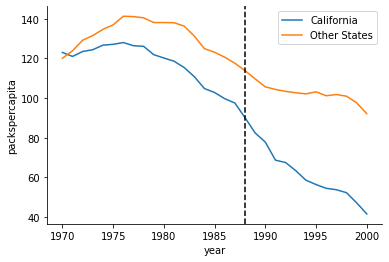

In [12]:
dat = data.assign(California = np.where(data.state=='California', 'California', 'Other States'))
dat = dat.groupby(['California', 'year']).packspercapita.mean().reset_index()
sns.lineplot(dat, x='year', y='packspercapita', hue='California')
plt.axvline(x=1988, linestyle='--', color='black')
plt.legend(title=None)

sns.despine()


### 2. Motivation for synthetic control
+ Traditional methodology chooses comparison units on the basis of subjective measures of affinity betrween control and treatment units.

+ There is uncertainty about the ability of the control unit to reproduce the counterfactual trajectory for the treatment unit in the absence of the treatment.

+ The combination of control units often provides a better comparison for the treatment unit than any single control unit alone.

### 3. Basic idea

we have a control cohort $Y_{T,co}$ with units from $1, ..., N$ and periods from $1, ..., T$, one treated cohort $Y_{T,tr}$ along same periods.
\begin{bmatrix}
    y_{1,1} & y_{1,2} & \cdots & y_{1,N} & y_{1,tr} \\
    y_{2,1} & y_{2,2} & \cdots & y_{2,N} & y_{2,tr} \\
    \vdots & \vdots & \ddots & \vdots & \vdots \\
    y_{pre,1} & y_{pre,2} & \cdots & y_{pre,N} & y_{pre,tr}\\
    y_{post,1} & y_{post,2} & \cdots & y_{post,N} & y_{post,tr}\\
    \vdots & \vdots & \ddots & \vdots & \vdots \\
    y_{T,1} & y_{T,2} & \cdots & y_{T,N} & y_{T,tr} \\
\end{bmatrix}

We only use the observations before the treatment to compute the weights: $W$

\begin{equation*}
\begin{bmatrix}
    y_{1,1} & y_{1,2} & \cdots & y_{1,N} \\
    y_{2,1} & y_{2,2} & \cdots & y_{2,N} \\
    \vdots & \vdots & \ddots & \vdots \\
    y_{pre,1} & y_{pre,2} & \cdots & y_{pre,N} \\
\end{bmatrix}

\begin{bmatrix}
w_1 \\
w_2 \\
\vdots \\
w_n
\end{bmatrix}

=
\begin{bmatrix}
y_{1, tr} \\
y_{2, tr} \\
\vdots \\
y_{pre, tr}
\end{bmatrix}
\end{equation*}
Then we use the estimated weights: $\hat{W}$ to compute the synthetic unit after the treatment (a.k.a the counterfactual).

\begin{equation*}
\begin{bmatrix}
    y_{post,1} & y_{post,2} & \cdots & y_{post,N} \\
    \vdots & \vdots & \ddots & \vdots \\
    y_{T,1} & y_{T,2} & \cdots & y_{T,N} \\
\end{bmatrix}

\begin{bmatrix}
\hat{w_1} \\
\vdots \\
\hat{w_n}
\end{bmatrix}

=
\begin{bmatrix}
y_{post, syn} \\
\vdots \\
y_{T, syn}
\end{bmatrix}

\end{equation*}

### 4. Consider synthetic control as a vertical linear regression

In [13]:
# choose only observations before treatment, and convert into wide dataset
data_wide = data.query("post==0").pivot(index='year', columns='state', values='packspercapita')
data_wide.head()

state,Alabama,Arkansas,California,Colorado,Connecticut,Delaware,Georgia,Idaho,Illinois,Indiana,...,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,West Virginia,Wisconsin,Wyoming
year,,,,,,,,,,,,,,,,,,,,,
1970,89.8,100.3,123.0,124.8,120.0,155.0,109.9,102.4,124.8,134.6,...,103.6,92.7,99.8,106.4,65.5,122.6,124.3,114.5,106.4,132.2
1971,95.4,104.1,121.0,125.5,117.6,161.1,115.7,108.5,125.6,139.3,...,115.0,96.7,106.3,108.9,67.7,124.4,128.4,111.5,105.4,131.7
1972,101.1,103.9,123.5,134.3,110.8,156.3,117.0,126.1,126.6,149.2,...,118.7,103.0,111.5,108.6,71.3,138.0,137.0,117.5,108.8,140.0
1973,102.9,108.0,124.4,137.9,109.3,154.7,119.8,121.8,124.4,156.0,...,125.5,103.5,109.7,110.4,72.7,146.8,143.1,116.6,109.5,141.2
1974,108.2,109.7,126.7,132.8,112.4,151.3,123.7,125.6,131.9,159.6,...,129.7,108.4,114.8,114.7,75.6,151.8,149.6,119.9,111.8,145.8


In [14]:
# regress cigarettes from donor pool on California
fit = sm.OLS(endog=data_wide[['California']], exog=data_wide.drop('California', axis=1)).fit()
weights = fit.params.values
weights

array([-0.00213476,  0.03645295,  0.10433371,  0.154935  , -0.02684143,
        0.00902368,  0.05063974,  0.10651957, -0.07509474,  0.01084688,
        0.10736682,  0.06824312,  0.0558362 ,  0.01604693,  0.06015975,
       -0.13284006, -0.03033186,  0.14161741,  0.11170248,  0.14081071,
        0.00952073,  0.06679418,  0.07497296, -0.06623468, -0.00923212,
       -0.04691436, -0.02469858, -0.025585  , -0.07343977, -0.01096652,
       -0.1117163 ,  0.08343876,  0.10906894, -0.09630024, -0.02751089,
        0.14305218,  0.08117366, -0.02890116])

In [15]:
synth_california = data.query("state!='California'").pivot(index='year', columns='state', values='packspercapita') @ weights
dat = data[data.state=='California'][['year', 'packspercapita']]
dat.columns = ['year', 'California']
dat['synth_ca'] = synth_california.values
dat.head()

,year,California,synth_ca
62,1970,123.0,123.0
63,1971,121.0,121.0
64,1972,123.5,123.5
65,1973,124.4,124.4
66,1974,126.7,126.7


In [16]:
print('The estimated ATT is: {:.3f}'.format((dat.California - dat.synth_ca).sum()/(2000-1988)))

The estimated ATT is: -15.419


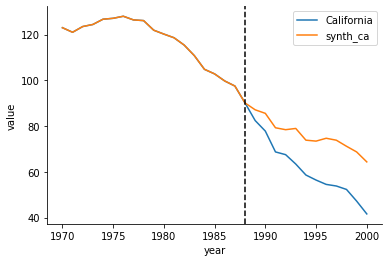

In [17]:
sns.lineplot(dat.melt(id_vars='year'), x='year', y='value', hue='variable')
plt.axvline(x=1988, linestyle='--', color='black')
plt.legend(title=None)
sns.despine()

### 5. Synthetic contorl without extrapolation

+ As we can see there is a perfect fit pre-treatment, that is because we have negative weights from OLS model, and these weights can not be expalianed explicitly. This is called extrapolation as discussed by `Abadie et al (2010)`. 

+ One way to prevent extrapolation is to restrict the weights to be non-nagetive and sum to one. It may not result in perfect match for the treated unit, but it create reasonable weights.

+ Transparency: make sure the synthethic control is weighted average of each control units, the contribution of each components is explicit.

\begin{equation}
\begin{aligned}

\hat{\omega}^{sc} &= \underset{\omega}{argmin}||Y_{pre, tr} - \omega Y_{pre, co}|| \\ 
& \text{s.t.} \ \sum\omega_i = 1 \ \text{and} \ \omega_i > 0

\end{aligned}
\end{equation}

+ We can generalize this to include covariates $Z_{i}$, a $(r × 1)$ vector of observed covariates (constant over time and not affected by the intervention) of unit $i$. $X_{it} = (Z_{i}, Y_{it})$ include both covariates and outcome vairable. Then the synthetic control tends to minimize the following function:

\begin{equation*}
\begin{aligned}
||\mathbf{X}_1 - \mathbf{X}_0 \mathbf{W} \|V &= \sqrt{(\mathbf{X}_1 - \mathbf{X}_0 \mathbf{W})'V(\mathbf{X}_1 - \mathbf{X}_0 \mathbf{W})} \\
& \text{s.t.} \ \sum\omega_i = 1 \ \text{and} \ \omega_i > 0

\end{aligned}
\end{equation*}

where $V$ is some $(k × k)$ (and $k=r+m$, $r$ is the number of covariates, $m$ is the number of periods) symmetric and positive semidefinite matrix with weights based on the importance of variables. This choice can be based on subjective assessments of the predictive power of the covariates in $X_1$ and $X_0$. It can also be data-driven to fit the pre-intervention period as good as you can.


In [18]:
from sklearn.utils.validation import check_X_y
from scipy.optimize import minimize, Bounds, LinearConstraint

In [19]:
# pivot contorl unit and treated unit
y_co_pre = data[(data.post==0) & (data.treated==0)].pivot(index='year', columns='state', values='packspercapita')
y_tr_pre = data[(data.post==0) & (data.treated==1)].packspercapita

In [35]:
# Checks X and y for consistent length, enforces X to be 2D and y 1D
X, y = check_X_y(y_co_pre, y_tr_pre)

# Initial guess for the weights: could be 0, uniform or based on some other logic
initial_w = (np.ones(X.shape[1])/X.shape[1])

# weigting matrix v, to assign weight to observations
v = np.diag(np.ones(X.shape[0])/X.shape[0])

# Define the objective function to minimize: the sum of squares of the residuals
def fun_obj(w, X, y, v):
    return np.mean(np.sqrt((y - X @ w).T @ v @ (y - X @ w)))

# Define the constraints: the weights should sum to 1
constraints = LinearConstraint(np.ones(X.shape[1]), lb= 1, ub= 1)

# Define the bounds: the weights should be between 0 and 1
bounds = Bounds(lb=0, ub=1)

# Use the SLSQP method which supports both bounds and constraints
result = minimize(fun_obj, x0=initial_w, args=(X, y, v), method='SLSQP', bounds=bounds, constraints=constraints)

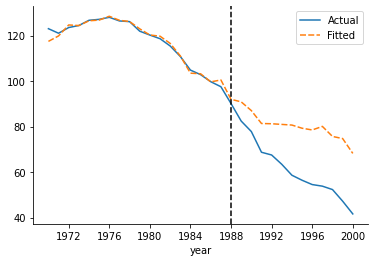

In [36]:
control = data[data.treated==0].pivot(index='year', columns='state', values='packspercapita')
treated = data[data.treated==1].packspercapita

X, y = check_X_y(control, treated)

# we use the weights to construct the synthetic CA
fitted = X @ result.x

df = pd.DataFrame(y, index=control.index, columns=['Actual'])
df['Fitted'] = fitted
df.index = pd.to_datetime(df.index, format='%Y')
# Plot both the actual and fitted data
sns.lineplot(df)
plt.axvline(x=pd.to_datetime('1988', format='%Y'), linestyle='--', color='black')
sns.despine()

In [46]:
print('The estimated ATT is: {:.3f}'.format((df.Actual - df.Fitted).sum()/(2000-1988)))

The estimated ATT is: -19.676


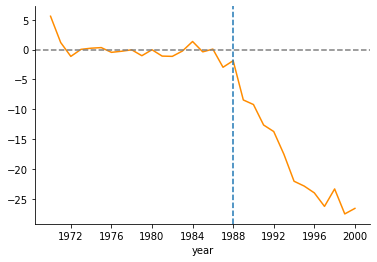

In [53]:
sns.lineplot((df.Actual - df.Fitted), color='darkorange')

plt.axhline(y=0, linestyle='--', color='gray')
plt.axvline(x=pd.to_datetime(1988, format='%Y'), linestyle='--')
sns.despine()

### 6. Inference with Fisher's sharp null

+ To assess significance, we calculate exact p-values under Fisher’s sharp null using a test statistic equal to after to before ratio of RMSPE.

+ Iteratively apply the synthetic method to each country/state in the donor pool and obtain a distribution of placebo effects.

+ the exact p-value is the treatment unit rank divided by J the number of total states.

In [127]:
# define a function to carry out synthetic control analysis
def synth(state, df):
    y_co_pre = df[(df.post==0) & (df.state!=state)].pivot(index='year', columns='state', values='packspercapita')
    y_tr_pre = df[(df.post==0) & (df.state==state)].packspercapita

    X, y = check_X_y(y_co_pre, y_tr_pre)

    # Initial guess for the weights: could be 0, uniform or based on some other logic
    initial_w = np.zeros(X.shape[1])

    # Define the objective function to minimize: the sum of squares of the residuals
    def fun_obj(w, X, y):
     return np.sum((X @ w - y) ** 2)

    # Define the equality constraint: the weights must sum to 1
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]

    # Define the bounds for w to be non-negative
    bounds = [(0, None)] * X.shape[1]

    # Use the SLSQP method which supports both bounds and constraints
    result = minimize(fun_obj, x0=initial_w, args=(X, y), method='SLSQP', bounds=bounds, constraints=constraints)

    # compute the synthetic state outcome
    fitted = df[df.state!=state].pivot(index='year', columns='state', values='packspercapita') @ result.x

    # append the fitted value to df

    return (df[df.state==state][['state', 'year', 'packspercapita', 'post']].assign(fitted=fitted.values, mse=result.fun))

In [128]:
from joblib import Parallel, delayed
from functools import partial

donor_pool = data.state.unique()

# use "delayed" to wrap up the partial function fixing the data we use each time
parallel_fun = delayed(partial(synth, df=data))

# with 5 job runing simultaneously 
synth_states = Parallel(n_jobs=8)(parallel_fun(state) for state in donor_pool)


In [129]:
dat = pd.concat(dat for dat in synth_states)
dat['diff'] = dat.packspercapita - dat.fitted

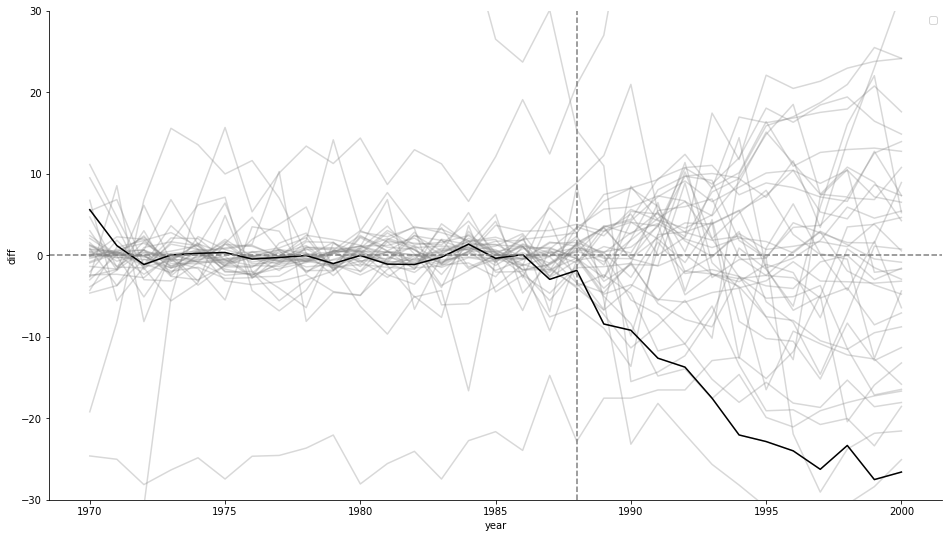

In [118]:
# Per-capita cigarette sales gaps in California and placebo gaps in all 38 control states.
fig, ax = plt.subplots(1, 1, figsize=(16, 9))

sns.lineplot(dat, x='year', y='diff', hue='state')
for line in ax.lines:
    line.set_color('gray')
    line.set_alpha(0.3)

sns.lineplot(dat[dat.state=='California'], x='year', y='diff', color='black')

ax.axvline(x=1988, linestyle='--', color='gray')
ax.axhline(y=0, linestyle='--', color='gray')
ax.legend('')
ax.set(ylim=(-30, 30))
sns.despine()

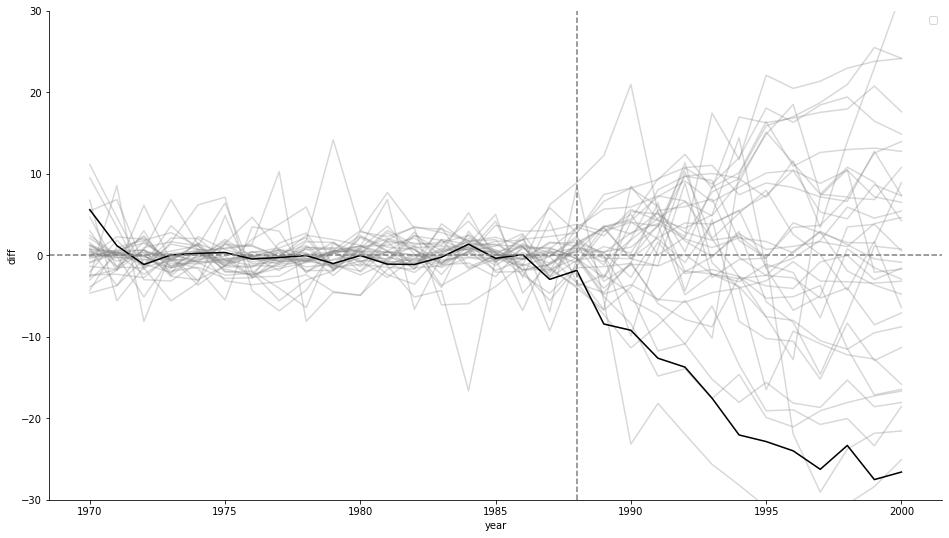

In [135]:
# Per-capita cigarette sales gaps in California and placebo gaps in 34 control states 
# (discards states with pre-Proposition 99 MSPE twenty times higher than California’s).
threshold = dat.query("state=='California'").mse.min()*20

fig, ax = plt.subplots(1, 1, figsize=(16, 9))

sns.lineplot(dat[dat.mse<=threshold], x='year', y='diff', hue='state')
for line in ax.lines:
    line.set_color('gray')
    line.set_alpha(0.3)

sns.lineplot(dat[dat.state=='California'], x='year', y='diff', color='black')

ax.axvline(x=1988, linestyle='--', color='gray')
ax.axhline(y=0, linestyle='--', color='gray')
ax.legend('')
ax.set(ylim=(-30, 30))
sns.despine()

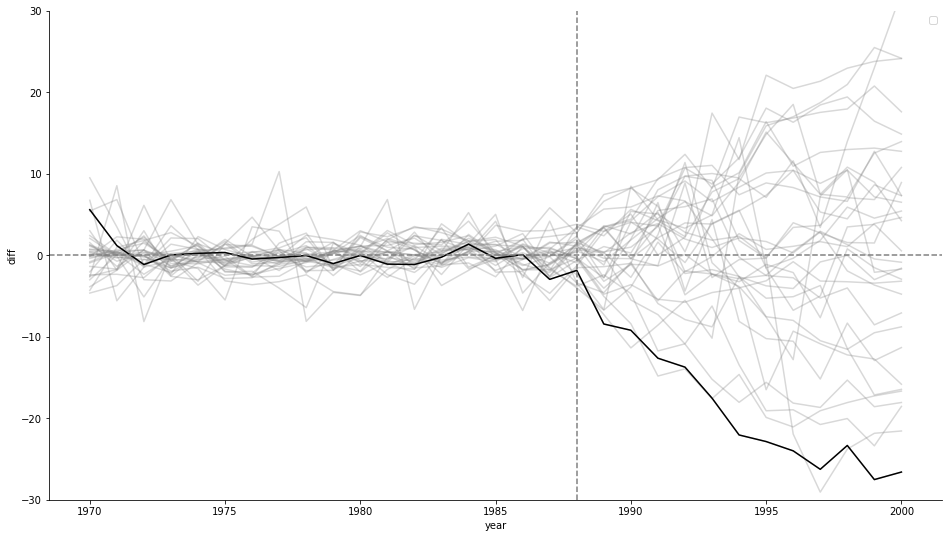

In [137]:
# Per-capita cigarette sales gaps in California and placebo gaps in 29 control states 
# (discards states with pre-Proposition 99 MSPE five times higher than California’s).
threshold = dat.query("state=='California'").mse.min()*5

fig, ax = plt.subplots(1, 1, figsize=(16, 9))

sns.lineplot(dat[dat.mse<=threshold], x='year', y='diff', hue='state')
for line in ax.lines:
    line.set_color('gray')
    line.set_alpha(0.3)

sns.lineplot(dat[dat.state=='California'], x='year', y='diff', color='black')

ax.axvline(x=1988, linestyle='--', color='gray')
ax.axhline(y=0, linestyle='--', color='gray')
ax.legend('')
ax.set(ylim=(-30, 30))
sns.despine()

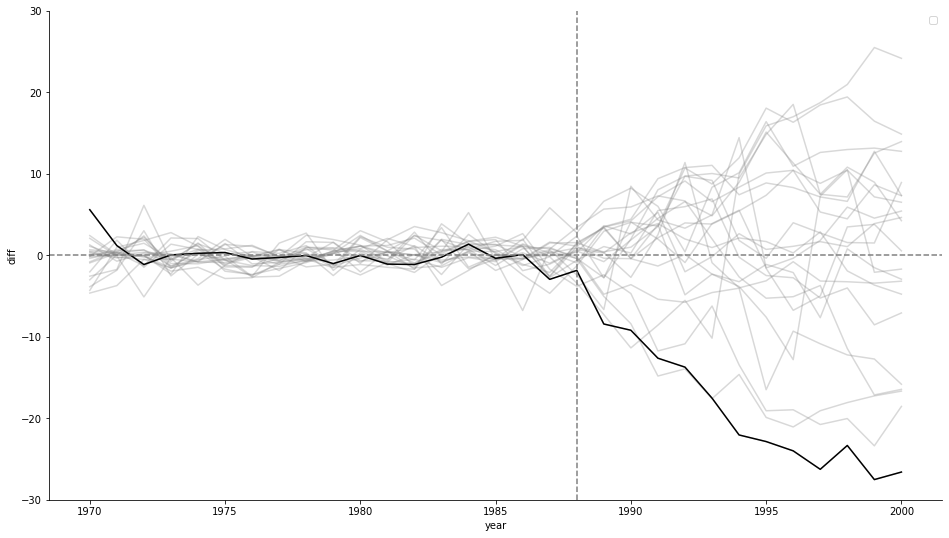

In [141]:
# Per-capita cigarette sales gaps in California and placebo gaps in 29 control states 
# (discards states with pre-Proposition 99 MSPE 2 times higher than California’s).
threshold = dat.query("state=='California'").mse.min()*2

fig, ax = plt.subplots(1, 1, figsize=(16, 9))

sns.lineplot(dat[dat.mse<=threshold], x='year', y='diff', hue='state')
for line in ax.lines:
    line.set_color('gray')
    line.set_alpha(0.3)

sns.lineplot(dat[dat.state=='California'], x='year', y='diff', color='black')

ax.axvline(x=1988, linestyle='--', color='gray')
ax.axhline(y=0, linestyle='--', color='gray')
ax.legend('')
ax.set(ylim=(-30, 30))
sns.despine()

### 7. More about inforence

+ `1. Standard Errors in Comparative Studies`

Traditional regression-based comparative case studies report standard errors reflecting uncertainty about aggregate data. Examples include studies by Card (1990) and Card and Krueger (1994) which analyze employment rates and the average number of employees in specific regions or sectors.

+ `2. Limitations of SE for Aggregate Data`

This mode of inference would logically produce zero standard errors if aggregate data were used for estimation. But since complete aggregate data does not eliminate all uncertainty in parameter estimation due to other sources of uncertainty beyond the data's unavailability. 

+ `3. Uncertainty Beyond Aggregate Data` 

Except the data, there is also uncertainty from the unknown potential of the control group to accurately replicate the counterfactual scenario of the treated unit without the treatment. This type of uncertainty is present regardless of whether aggregate data are used for estimation or not.

+ `4. Inferential Techniques for Small Samples (e.g. aggregated data)`

Standard large sample inferential techniques are not always appropriate when the comparison group is small. But the exact inferential techniques similar to permutation tests, suitable regardless of the data scale or the number of comparison units.

+ `5. Placebo Tests (Falsification) in Literature`

Under the frame of permutation test, placebo or falsification tests are widespread in various studies, assessing different aspects such as wage distribution, unemployment rates, and addiction models, when the comparison group is small.

+ `6. Quantitative Inference via Placebo Studies`

Apply the synthetic control method to every potential control in the sample. With all the estimates, we can construct a excat distribution of the estimated effect of the placebo interventions. This is informative inference if under the hypothesis of no intervention effect, the estimated effect of the intervention is not expected to be abnormal relative to the distribution of the placebo effects.

+ `7. Randomization Inference`

The proposed inferential exercise is exact and provides classical randomization inference when the intervention is randomized, comparing the actual intervention's effect with the estimated effects for regions not exposed to the intervention.

+ `8. Related Literature`

The approach is related to recent developments in inferential methods and surveys provided by authors like Wooldridge and Imbens (2008), and discussions by Rosenbaum (2002a, 2002b) on permutation inference in randomized and observational studies.


### **Prove**

\begin{equation}
\tag{1}
Y^{N}_{it} = \delta_{t} + \theta_t Z_{i} + \lambda_t \mu_{i} + \varepsilon_{it}
\end{equation}

Each particular value of the vector W represents a potential synthetic control, that is, a particular weighted average of control regions. The value of the outcome variable for each synthetic control indexed by $W$ is:

\begin{equation*}
\sum_{j=2}^{J+1} w_{j}Y^{N}_{jt} = \delta_{t} + \theta_{t} \left( \sum_{j=2}^{J+1} w_{j}Z_{j} \right) + \lambda_{t} \left( \sum_{j=2}^{J+1} w_{j}\mu_{j} \right) + \sum_{j=2}^{J+1} w_{j}\varepsilon_{jt}.
\end{equation*}


Suppose that there are $w^*_2, \ldots, w^*_{J+1}$ such that

\begin{equation}
\tag{2}

\begin{split}
\sum_{j=2}^{J+1} w^*_j Y_{j1} &= Y_{11}, \qquad \sum_{j=2}^{J+1} w^*_j Y_{j2} = Y_{12}, \qquad \ldots, \\
\sum_{j=2}^{J+1} w^*_j Y_{jT_0} &= Y_{1T_0}, \qquad \sum_{j=2}^{J+1} w^*_j Z_j = Z_1
\end{split}

\end{equation}

The outcome of treated substract that of control:

\begin{equation}
\tag{3}
y^{N}_{1t} - \sum_{j=2}^{J+1} w_{j}y^{N}_{jt} = \theta_{t} \left( Z_{1} - \sum_{j=2}^{J+1} w_{j}Z_{j} \right) + \lambda_{t} \left( \mu_{1} - \sum_{j=2}^{J+1} w_{j}\mu_{j} \right) + \sum_{j=2}^{J+1} w_{j}(\varepsilon_{1t} - \varepsilon_{jt}).
\end{equation}


To estimate the weights we only use observations before treatment that is period $p \in (1, ..., T_O)$

\begin{equation}
\tag{4}
Y^{P}_{1} - \sum_{j=2}^{J+1} w_{j}Y^{P}_{j} = \theta^{P} \left( Z_{1} - \sum_{j=2}^{J+1} w_{j}Z_{j} \right) + \lambda^{P} \left( \mu_{1} - \sum_{j=2}^{J+1} w_{j}\mu_{j} \right) + \sum_{j=2}^{J+1} w_{j}(\varepsilon^{P}_{1} - \varepsilon^{P}_{j})
\end{equation}


Since $\mu_j$ is unobservable, we need to fisrt eliminate it. Suppose $\lambda^{P\prime}\lambda^{P}$ is non-sigular, we use Equation (3) $ - \lambda_t(\lambda^{P\prime}\lambda^P)^{-1}\lambda^{P\prime} * $ Equation (4) to get:

\begin{equation}
\tag{5}

\begin{split}
Y^{N}_{1t} - \sum_{j=2}^{J+1} w_{j}Y^{N}_{jt} =& \lambda_{t}(\lambda^{P\prime} \lambda^{P})^{-1} \lambda^{P\prime} \left( Y^{P}_{1} - \sum_{j=2}^{J+1} w_{j}Y^{P}_{j} \right) \\
&+ (\theta_{t} - \lambda_{t}(\lambda^{P\prime} \lambda^{P})^{-1} \lambda^{P\prime} \theta^P) \left( Z_{1} - \sum_{j=2}^{J+1} w_{j}Z_{j} \right) \\
&+ \sum_{j=2}^{J+1} w_{j}(\varepsilon_{1t} - \varepsilon_{jt}) - \lambda_t(\lambda^{P\prime} \lambda^{P})^{-1} \lambda^{P\prime} \left( \varepsilon^{P}_{1} - \sum_{j=2}^{J+1} w_{j}\varepsilon^{P}_{j} \right)
\end{split} 
\end{equation}

The $\mu_j$ in the second terms on the right hand side of both Equation 3 and Equation 4 are concelled out by substraction.

Then the first and second terms on the RHS of Equation 5 are cancelled based on the assumption Equation 2, 

$$
Y^N_{1t} - \sum_{j=2}^{J+1} w^*_jY^N_{jt} = R_{1t} + R_{2t} + R_{3t},
$$

where

$$
R_{1t} =\lambda_{t}(\lambda^{P\prime} \lambda^{P})^{-1} \lambda^{P\prime} \left( \sum_{j=2}^{J+1} w^*_j\varepsilon^P_j \right)
$$ 


$$
R_{2t} = -\lambda_{t}(\lambda^{P\prime} \lambda^{P})^{-1} \lambda^{P\prime} \varepsilon^P_1
$$

$$
R_{3t} = \sum_{j=2}^{J+1} w^*_j (\varepsilon_{jt} - \varepsilon_{1t})
$$

Consider the case of $t > T_0$ that is in the period post treatment. Then, $R_{2t}$ and $R_{3t}$ have mean zero. Notice that,
$$
R_{1t} = \sum_{j=2}^{J+1} w^*_j \sum_{s=1}^{T_0} \lambda_{t} \left( \sum_{n=1}^{T_0} \lambda'_{n} \lambda_{n} \right)^{-1} \lambda'_{s} \varepsilon_{js}.
$$



Now let's focus on the first term $R_{1t}$. Because $\sum_{t=1}^{T_0} \lambda'_t \lambda_t$ is symmetric and positive definite, so is its inverse. Then, applying the Cauchy–Schwarz Inequality, we obtain
$$
\left( \lambda_t \left(\sum_{n=1}^{T_0} \lambda'_n \lambda_n \right)^{-1} \lambda'_s \right)^2
\leq \left( \lambda_t \left(\sum_{n=1}^{T_0} \lambda'_n \lambda_n \right)^{-1} \lambda'_t \right)
\left( \lambda_s \left(\sum_{n=1}^{T_0} \lambda'_n \lambda_n \right)^{-1} \lambda'_s \right)
\leq \left( \frac{\bar{\lambda}^2_F}{T_0 \underline{\xi}} \right)^2 .
$$


Let
$$
\bar{\varepsilon}^L_j = \sum_{s=1}^{T_0} \lambda_t \left( \sum_{n=1}^{T_0} \lambda'_n \lambda_n \right)^{-1} \lambda'_s \varepsilon_{js}
$$
for $ j = 2, \ldots, J+1 $.
Assume that, for some even $p$, the $p^{th}$ moments of $|\varepsilon_{jt}|$ exist for $j = 2, \ldots, J+1$ and $t = 1, \ldots, T_0$. Using $H\"{o}lder's$ Inequality:
$$
\sum_{j=2}^{J+1} w^*_j |\bar{\varepsilon}^L_j| \leq \left( \sum_{j=2}^{J+1} w^*_j |\bar{\varepsilon}^L_j|^p \right)^{1/p} \leq \left( \sum_{j=2}^{J+1} |\bar{\varepsilon}^L_j|^p \right)^{1/p}.
$$


Therefore, applying again $H\"older's$ Inequality:
$$
E\left[ \sum_{j=2}^{J+1} w^*_j \bar{\varepsilon}_j^L \right] \leq \left( E\left[ \sum_{j=2}^{J+1} |\bar{\varepsilon}_j^L|^p \right] \right)^{1/p} .
$$

Now, using Rosenthal's Inequality:
$$
E|\bar{\varepsilon}_j^L|^p \leq C(p) \left( \frac{\lambda^2_F}{\xi} \right)^p \max \left\{ \left( \frac{1}{T_0} \sum_{t=1}^{T_0} E|\varepsilon_{jt}|^p \right), \left( \frac{1}{T_0^2} \sum_{t=1}^{T_0} E|\varepsilon_{jt}|^2 \right)^{p/2} \right\} .
$$


where $C(p)$ is the $p^{th}$ moment of minus one plus a Poisson random variable with parameter equal to one (see Ibragimov and Sharakhmetov 2002). Let
$$
\sigma^2_{jt} = E\varepsilon_{jt}^2, \quad \sigma^2_j = \left(\frac{1}{T_0}\sum_{t=1}^{T_0} \sigma^2_{jt}\right), \quad \bar{\sigma}^2 = \max_{j=2,\ldots,J+1} \sqrt{\delta^2}, \quad \bar{\sigma} = \sqrt{\bar{\sigma}^2}
$$

Similarly, let
$$m_{p,jt} = E|\varepsilon_{jt}|^p, \quad m_{p,j} = \frac{1}{T_0}\sum_{t=1}^{T_0} m_{p,jt}, \quad \tilde{m}_p = \max_{j=2,\ldots,J+1} m_{p,j}
$$
We obtain that, for $t > T_0$,
$$
E|R_{1t}| \leq C(p)^{1/p} \left(\frac{\hat{\lambda}^2 F}{\underline{\xi}}\right) J^{1/p} \max\left\{\frac{\bar{m}^{1/p}_p}{T^{1-1/p}_0}, \frac{\bar{\sigma}}{T^{1/2}_0}  \right\}.
$$

This last equation implies that the bias of the estimator can be bounded by a function that goes to zero **_as the number of pretreatment periods increases_**.

Synthetic controls can provide useful estimates in more general contexts than the factor model considered in Equation (1), e.g. this AR model with time-varying coefficients:

\begin{align*}
Y^{N}_{it+1} &= \alpha_t Y^{N}_{it} + \beta_{t+1} Z_{it+1} + u_{it+1}, \\

Z_{it+1} &= \gamma_t Y^{N}_{it} + \Pi_{t} Z_{it} + v_{it+1},
\end{align*}

For the post-treatment period the AR model can be written as:

$$
Y^{N}_{iT_0+1} = (\alpha_{T_0} + \beta_{T_0+1}\gamma_{T_0})Y_{iT_0} + \beta_{T_0+1}\Pi_{T_0}Z_{iT_0} + \beta_{T_0+1}v_{iT_0+1} + u_{iT_0+1}
$$


where $u_{it+1}$ and $v_{it+1}$ have mean zero conditional on $\mathcal{F}_t = \{Y_{js}, Z_{js}\}_{1 \leq j \leq N, s \leq t}$. Suppose that we can choose $\{w_j^{*}\}_{2 \leq j \leq N}$ such that:

$$
\sum_{j=2}^{J+1} w_j^{*} Y_{jT_0} = Y_{1T_0} \quad \text{ and } \quad \sum_{j=2}^{J+1} w_j^{*} Z_{jT_0} = Z_{1T_0}
$$

Then, the synthetic control estimator is unbiased even if data for only a single pretreatment period are available. As we have proved before!

## Build the package

In [347]:
from sklearn.utils.validation import check_X_y, check_is_fitted, check_array
from sklearn.base import BaseEstimator, RegressorMixin

from scipy.optimize import minimize

In [375]:
class Synth(BaseEstimator, RegressorMixin):

    def __init__(self, ):
        pass
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)

        initial_w = np.zeros(X.shape[1])

        def fun_obj(w, X, y):
            return np.sum((X @ w - y) ** 2)
        constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
        bounds = [(0, None)] * X.shape[1]

        result = minimize(fun_obj, x0=initial_w, args=(X, y), method='SLSQP', bounds=bounds, constraints=constraints)

        self.X_ = X
        self.y_ = y
        self.w_ = result.x

        self.is_fitted_ = True
        return self
    
    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        return X @ self.w_

In [376]:
# fit the model
synth_model = Synth()
synth_fit = synth_model.fit(y_co_pre, y_tr_pre)

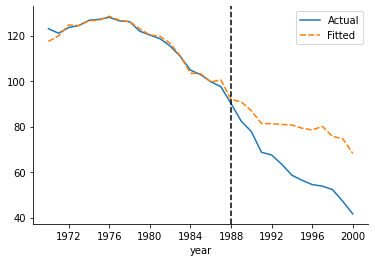

In [382]:
control = data[data.treated==0].pivot(index='year', columns='state', values='packspercapita')
treated = data[data.treated==1].packspercapita.values

# predict
fitted = synth_model.predict(control)

df = pd.DataFrame(treated, index=control.index, columns=['Actual'])
df['Fitted'] = fitted
df.index = pd.to_datetime(df.index, format='%Y')
# Plot both the actual and fitted data
sns.lineplot(df)
plt.axvline(x=pd.to_datetime('1988', format='%Y'), linestyle='--', color='black')
sns.despine()